##Imports

In [ ]:
!pip install -U wapi-python

In [ ]:
import wapi
session = wapi.Session(client_id='OeXk_h.ntyBg6u.XKAI8ABL.EwO9SVr3', client_secret='ctDxT-K-QxltY_DStKkSI9.bUT7Yv1hXI7ycnYjsZQWvddQBWCPpdAHnTFtp4Lplrf1VWN_Tas0Xb4QDrwrmxlYdklMAcvsH8lRj')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Add Normal PV Production

<Axes: >

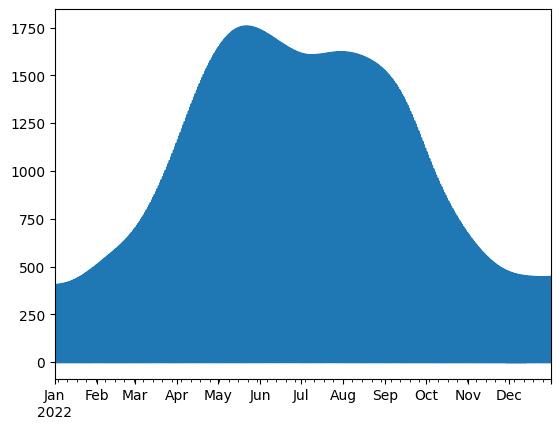

In [ ]:
#create function to call normal PV using only the start and end date as input variables


def get_normal_prod(start_date, end_date):

  ## TIME_SERIES curve
  curve = session.get_curve(name='pro ch spv mwh/h cet min15 n')

  ## Hourly average aggregation
  # read curve data from start_date to end_date to ts object and
  # aggregate to hourly frequency
  ts1h = curve.get_data(data_from=start_date, data_to=end_date, function='AVERAGE',
                      frequency='H')

  # convert to pandas.Series object
  pd_s = ts1h.to_pandas() # convert TS object to pandas.Series object
  pd_df = pd_s.to_frame() # convert pandas.Series to pandas.DataFrame


  return pd_s


normal_prod = get_normal_prod(start_date = "2022-01-01" , end_date = "2023-01-01")

normal_prod.plot()



##Add Actual PV Production

<Axes: >

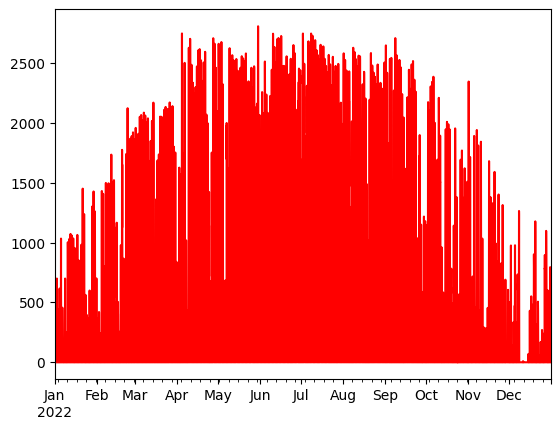

In [ ]:
def get_actual_prod(start_date, end_date):

  ## TIME_SERIES curve
  curve_a = session.get_curve(name='pro ch spv mwh/h cet min15 a')

  ## Hourly average aggregation
  # read curve data from start_date to end_date to ts object and
  # aggregate to hourly frequency
  ts1h_a = curve_a.get_data(data_from=start_date, data_to=end_date, function='AVERAGE',
                      frequency='H')

  # convert to pandas.Series object
  pd_s_a = ts1h_a.to_pandas() # convert TS object to pandas.Series object
  pd_df_a = pd_s_a.to_frame() # convert pandas.Series to pandas.DataFrame


  return pd_s_a


actual_prod = get_actual_prod(start_date = "2022-01-01" , end_date = "2023-01-01")

actual_prod.plot(color='red')


##Add Spot price curve

<Axes: >

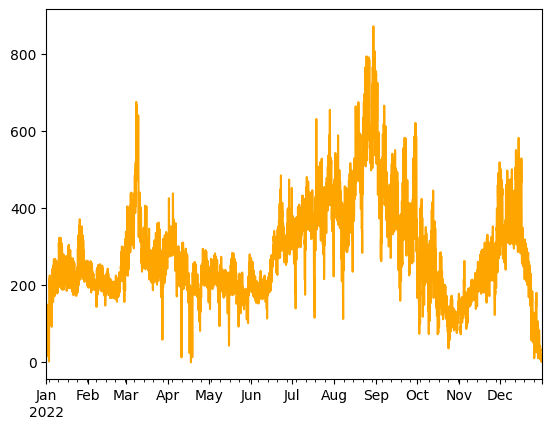

In [ ]:
def get_spot_price(start_date, end_date):


  ## TIME_SERIES curve
  curve_sp = session.get_curve(name='pri ch spot €/mwh cet h a')

  ## Hourly average aggregation
  # read curve data from start_date to end_date to ts object and
  # aggregate to hourly frequency
  ts1h_sp = curve_sp.get_data(data_from=start_date, data_to=end_date, function='AVERAGE', frequency = 'H'
                      )

  # convert to pandas.Series object
  pd_s_sp = ts1h_sp.to_pandas() # convert TS object to pandas.Series object
  pd_df_sp = pd_s_sp.to_frame() # convert pandas.Series to pandas.DataFrame


  return pd_s_sp



spot_price = get_spot_price(start_date = "2022-01-01" , end_date = "2023-01-01")

spot_price.plot(color='orange')

##Add capacity curve Switzerland

<Axes: >

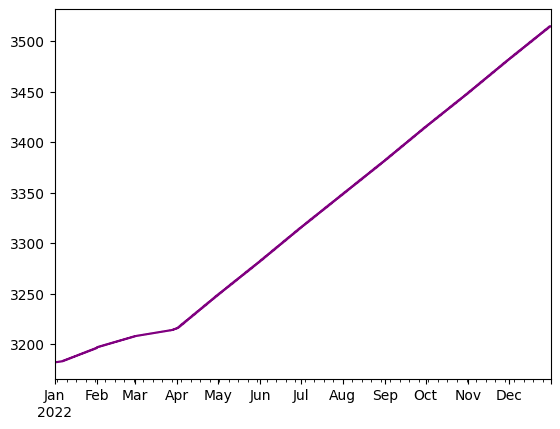

In [ ]:
def get_cap_curve(start_date, end_date):


  ## TIME_SERIES curve
  curve_cap = session.get_curve(name='cap ch spv mw cet min15 a')

  ## Hourly average aggregation
  # read curve data from start_date to end_date to ts object and
  # aggregate to hourly frequency
  ts1h_cap = curve_cap.get_data(data_from=start_date, data_to=end_date, function='AVERAGE', frequency = 'H'
                      )

  # convert to pandas.Series object
  pd_s_cap = ts1h_cap.to_pandas() # convert TS object to pandas.Series object
  pd_df_cap = pd_s_cap.to_frame() # convert pandas.Series to pandas.DataFrame


  return pd_s_cap


cap_curve = get_cap_curve(start_date = "2022-01-01" , end_date = "2023-01-01")
cap_curve.plot(color='purple')

## Compute P&L

In [ ]:
##input required : actual PV prod, pred PV prod, spot price

##LOGIC: for each hour, do the following

#1) CALC PNL Spot (= Price_spot * Energy_Spot)



def pnl(actual_prod, pred_prod, spot_price, tot_cap):


  #PRE-ELIMINARY: Scale down the total Swiss production to our PV plant

  actual_prod = (actual_prod / tot_cap) * 10
  pred_prod = (pred_prod / tot_cap) * 10




  #List of hourly pnl's (will be converted to Series later)
  pnl_final = []


  for actual_prod_h,pred_prod_h,spot_price_h in zip(actual_prod.values, pred_prod.values, spot_price.values):

    pnl_spot = spot_price_h * pred_prod_h

    energy_imb = actual_prod_h - pred_prod_h


    #case of excess energy available:
    if energy_imb > 0:
      #sell at disadvantageous price
      price_imb = spot_price_h * 0.7

    # case of lack of energy
    elif energy_imb < 0:
      #buy at expensive price
      price_imb = spot_price_h * 1.3

    #case of perfect balance
    else:
      price_imb = 0


    pnl_imb = price_imb * energy_imb

    pnl_h = pnl_spot + pnl_imb


    pnl_final.append(pnl_h)


  #copy one of the Series
  pnl_final_series = actual_prod.copy()

  pnl_final_series.values[:] = pnl_final


  return pnl_final_series, pnl_final_series.sum()


final, final_sum = pnl(actual_prod, normal_prod, spot_price, cap_curve)

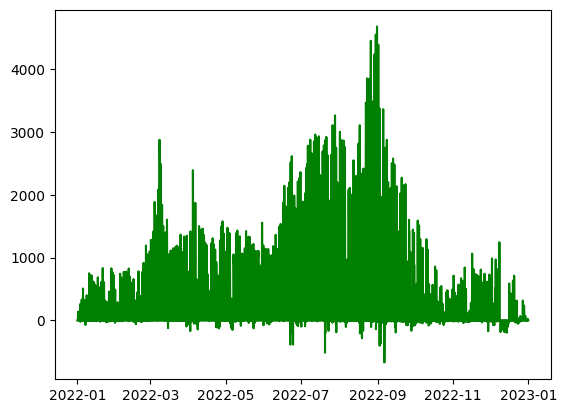

In [ ]:
plt.plot(final, color='green')

##ARIMA model (discontinued)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

Model hyperparameter tuning

In [ ]:
"""
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# Define a function to train ARIMA model
def train_arima_model(series, order_range):
    best_rmse = float('inf')
    best_params = None
    for p in order_range:
        for d in order_range:
            for q in order_range:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    result = model.fit()
                    rmse = sqrt(mean_squared_error(series, result.fittedvalues))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {'order': (p, d, q)}
                except:
                    continue
    return best_params

# Define the range of hyperparameters to search over
order_range = range(0, 5)  # Example range for p, d, q

# Train ARIMA model
best_params = train_arima_model(actual_prod, order_range)
print('Best ARIMA Model Parameters:', best_params)
"""

"\nimport pandas as pd\nfrom statsmodels.tsa.arima.model import ARIMA\nfrom sklearn.metrics import mean_squared_error\nfrom math import sqrt\n\n\n# Define a function to train ARIMA model\ndef train_arima_model(series, order_range):\n    best_rmse = float('inf')\n    best_params = None\n    for p in order_range:\n        for d in order_range:\n            for q in order_range:\n                try:\n                    model = ARIMA(series, order=(p, d, q))\n                    result = model.fit()\n                    rmse = sqrt(mean_squared_error(series, result.fittedvalues))\n                    if rmse < best_rmse:\n                        best_rmse = rmse\n                        best_params = {'order': (p, d, q)}\n                except:\n                    continue\n    return best_params\n\n# Define the range of hyperparameters to search over\norder_range = range(0, 5)  # Example range for p, d, q\n\n# Train ARIMA model\nbest_params = train_arima_model(actual_prod, order_range

Model simple PnL : Train on all year except last 24 hrs, test on last 24 hours

In [ ]:
type(actual_prod.iloc[-10:])

pandas.core.series.Series

In [ ]:
##Split the relevant Pnl inputs into training and testing

actual_prod_train = actual_prod.iloc[:-24]
actual_prod_test = actual_prod.iloc[-24:]

spot_price_test = spot_price.iloc[-24:]
cap_curve_test = cap_curve.iloc[-24:]


# Train the ARIMA model on the training set
model = ARIMA(actual_prod_train, order=(2,1,2))
model_fit = model.fit()

# Use the fitted model to forecast the next 24 hours
forecast = model_fit.forecast(steps=24)


#Do the Pnl on the forecasted last 24 hours

ARIMA_final, ARIMA_final_sum = pnl(actual_prod_test,forecast,spot_price_test,cap_curve_test)

KeyboardInterrupt: 

In [ ]:
#ARIMA_final.plot(color='green')
actual_prod_test.plot(color='red')
forecast.plot(color='blue')

skippy

In [ ]:
ARIMA_final.plot()

In [ ]:
ARIMA_final_sum

##Cross-validation metric using PnL

In [ ]:
#Min training size: 2 months
#step size: 1 month
#testing size: 1 day
#Start year: 2020 (2018 better?)
#End year: 2022

def rolling_window_cross_validation(series, actual_prod, order, train_start=1440, step_size=720, test_size=36):
    #rmse_scores = []

    pnl_plots = []
    pnl_scores = []

    # Calculate the total number of iterations
    total_iterations = (len(series) - train_start - test_size) // step_size + 1



    # Iterate through the time series in rolling windows
    for i in range(1,total_iterations):


        # Define the training and testing sets for this iteration
        train_end = train_start + i * step_size
        train_data = series.iloc[:train_end]

        test_data = series.iloc[train_end:train_end + test_size]


        actual_prod_test = actual_prod.iloc[train_end:train_end + test_size]
        spot_price_test = spot_price.iloc[train_end:train_end + test_size]
        cap_curve_test = cap_curve.iloc[train_end:train_end + test_size]



        ####################################################

        # Train ARIMA model (or any model for that matter)
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        # Make predictions for the next 24 hours
        forecast = model_fit.forecast(steps=test_size)


        ####################################################


        pnl_final, pnl_final_sum = pnl(actual_prod_test,forecast,spot_price_test,cap_curve_test)

        pnl_plots.append(pnl_final)
        pnl_scores.append(pnl_final_sum)
        # Calculate RMSE for the predictions
        #rmse = sqrt(mean_squared_error(test_data, forecast))
        #rmse_scores.append(rmse)

    return pnl_plots, pnl_scores


# Example usage:
#pnl_scores = rolling_window_cross_validation(actual_prod, actual_prod, (2,1,2))
print('PNL Scores:', pnl_scores)


KeyboardInterrupt: 

In [ ]:
sum(pnl_scores[1]) / len(pnl_scores[1])

8885.530486160233

<Axes: >

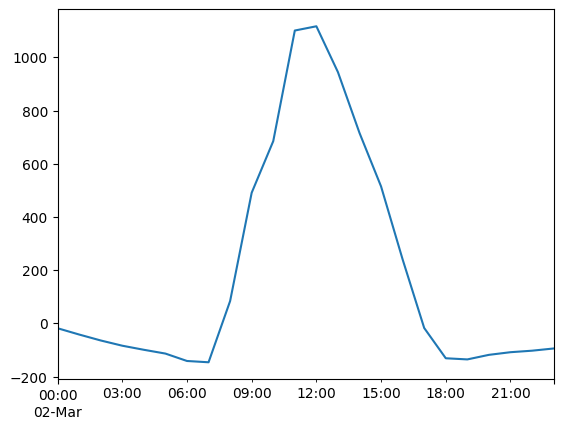

In [ ]:
pnl_scores[0][0].plot()

In [ ]:
pnl_scores[0]

[2022-03-02 00:00:00+01:00     -18.348243
 2022-03-02 01:00:00+01:00     -41.986793
 2022-03-02 02:00:00+01:00     -64.335230
 2022-03-02 03:00:00+01:00     -84.006841
 2022-03-02 04:00:00+01:00     -99.330316
 2022-03-02 05:00:00+01:00    -113.567844
 2022-03-02 06:00:00+01:00    -141.386239
 2022-03-02 07:00:00+01:00    -146.269058
 2022-03-02 08:00:00+01:00      83.922015
 2022-03-02 09:00:00+01:00     490.957720
 2022-03-02 10:00:00+01:00     684.916665
 2022-03-02 11:00:00+01:00    1100.654379
 2022-03-02 12:00:00+01:00    1116.641947
 2022-03-02 13:00:00+01:00     944.211978
 2022-03-02 14:00:00+01:00     715.646539
 2022-03-02 15:00:00+01:00     514.502300
 2022-03-02 16:00:00+01:00     240.173412
 2022-03-02 17:00:00+01:00     -17.481732
 2022-03-02 18:00:00+01:00    -131.172180
 2022-03-02 19:00:00+01:00    -135.504877
 2022-03-02 20:00:00+01:00    -118.348621
 2022-03-02 21:00:00+01:00    -108.407949
 2022-03-02 22:00:00+01:00    -102.745056
 2022-03-02 23:00:00+01:00     -94

##LSTM 1D

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the sequence length (number of time steps to look back)


sequence_length = 24  # Use the past 24 hours to predict the next 24 hours

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(actual_prod.values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - 24):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+24])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, sequence_length)

Real bad man below

In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(actual_prod.values.reshape(-1, 1))

# Define the sequence length (number of time steps to look back)
sequence_length = 24  # Use the past 24 hours to predict the next 24 hours

# Prepare the data for Encoder-Decoder LSTM
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - 24):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+24])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Encoder-Decoder LSTM model
# Encoder
encoder_inputs = Input(shape=(sequence_length, 1))
encoder = LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(24, 1))
decoder_lstm = LSTM(units=128, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(units=1)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit([X_train, X_train], y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
train_loss = model.evaluate([X_train, X_train], y_train, verbose=0)
test_loss = model.evaluate([X_test, X_test], y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

# Make predictions
predictions = model.predict([X_test, X_test])

# Inverse transform the predictions to original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 24))

# Print or use the predictions
print('Predictions:', predictions)


Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_6" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 24, 1) dtype=float32>]


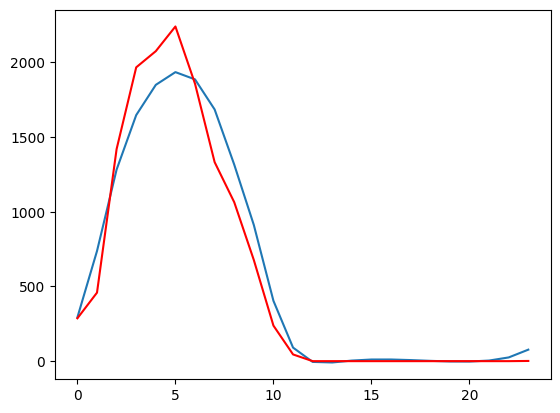

In [ ]:
y_tout2= scaler.inverse_transform(y_test.reshape(-1, 24))



plt.plot(predictions[5])
plt.plot(y_tout2[5] ,color='red')

Old one below

In [ ]:


# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Encoder-Decoder LSTM model
# Encoder
encoder_inputs = Input(shape=(sequence_length, 1))
encoder = LSTM(units=50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(24, 1))
decoder_lstm = LSTM(units=50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(units=1)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_train, X_train], y_train, epochs=100, batch_size=32)

# Evaluate the model
train_loss = model.evaluate([X_train, X_train], y_train, verbose=0)
test_loss = model.evaluate([X_test, X_test], y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

# Make predictions
predictions = model.predict([X_test, X_test])

# Inverse transform the predictions to original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 24))

# Print or use the predictions
print('Predictions:', predictions)

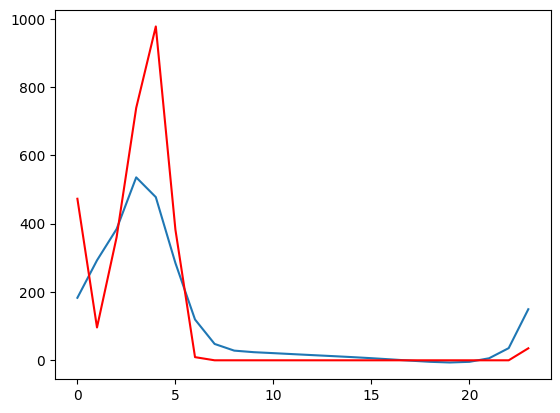

In [ ]:
#plt.plot(predictions[-2])
#y_tout= scaler.inverse_transform(y_test.reshape(-1, 24))



plt.plot(predictions[2000])
plt.plot(y_tout[2000] ,color='red')

In [ ]:
y_test[-2]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00065834],
       [0.07702523],
       [0.19618393],
       [0.28308419],
       [0.26991748],
       [0.2330507 ],
       [0.17116718],
       [0.09282528],
       [0.0111917 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

##Data Augmentation (output is FINAL)

Features to be added: cloud forecast, Windspeed, Temperature, Observed Consumption

In [ ]:
#Feature Curves

PV_CAPACITY = "cap ch spv mw cet min15 a"

CLOUD_FORECAST = 'cc ch con ec00 % cet min15 f'

WIND_SPEED = ["ff ch grimsel test m/s cet h s",
                   "ff ch adelboden test m/s cet h s",
                   "ff ch geneve test m/s cet h s",
                   "ff ch davos test m/s cet h s",
                   "ff ch engelberg test m/s cet h s",
                   "ff ch bern test m/s cet h s",
                   "ff ch lugano test m/s cet h s",
                   "ff ch zurich test m/s cet h s",
                   "ff ch samedan test m/s cet h s"]

TEMPERATURES = ["tt ch grimsel test °c cet h s",
                    "tt ch adelboden test °c cet h s",
                    "tt ch geneve test °c cet h s",
                    "tt ch davos test °c cet h s",
                    "tt ch engelberg test °c cet h s",
                    "tt ch bern test °c cet h s",
                    "tt ch lugano test °c cet h s",
                    "tt ch zurich test °c cet h s",
                    "tt ch samedan test °c cet h s"]


OBSERVED_CONSUMPTION = "con ch mwh/h cet min15 a"


Y = ACTUAL_PV_PRODUCTION = "pro ch spv mwh/h cet min15 a"


In [ ]:
def merge_mean(curves, session, data_from="2022-01-01", data_to="2022-12-31"):
  assert len(curves) > 0

  c = session.get_curve(name=curves[0])
  ts = c.get_data(data_from=data_from, data_to=data_to)
  res = ts.to_pandas().to_frame()

  for index, curve in enumerate(curves):
    if index == 0:
      continue

    tmp_c = session.get_curve(name=curve)
    tmp = tmp_c.get_data(data_from=data_from, data_to=data_to)
    res = res.join(tmp.to_pandas().to_frame())

  res = res.mean(axis=1).to_frame()
  res.rename(columns = {0:curves[0][:2]}, inplace = True)
  return res

In [ ]:
def generate_continuous(from_date = "2022-01-01", to_date = "2023-01-01"):
    features = []

    ## Installed PV Capacity - cap
    Installed_PV = session.get_curve(name=PV_CAPACITY)
    ts_Installed_PV = Installed_PV.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
    df_Installed_PV = ts_Installed_PV.to_pandas().to_frame()
    df_Installed_PV.rename(columns = {PV_CAPACITY: 'cap'}, inplace = True)

    ## Windspeed - ff
    df_wind_speed = merge_mean(WIND_SPEED, session, from_date, to_date)
    features.append(df_wind_speed)

    ## Temperatures - tt
    df_temperature = merge_mean(TEMPERATURES, session, from_date, to_date)
    features.append(df_temperature)

    ## Observed Consumption - con
    consumption = session.get_curve(name=OBSERVED_CONSUMPTION)
    ts_consumption = consumption.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
    df_consumption = ts_consumption.to_pandas().to_frame()
    df_consumption.rename(columns = {OBSERVED_CONSUMPTION : 'con'}, inplace = True)
    features.append(df_consumption)

    actual_pv_prod = session.get_curve(name=ACTUAL_PV_PRODUCTION)
    ts_actual_pv_prod = actual_pv_prod.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
    df_actual_pv_prod = ts_actual_pv_prod.to_pandas().to_frame()
    df_actual_pv_prod.rename(columns = {ACTUAL_PV_PRODUCTION : 'y'}, inplace = True)
    features.append(df_actual_pv_prod)


    return df_Installed_PV.join(features)

In [ ]:
START_TIME = "2022-01-01T00:00"
END_TIME = "2023-01-01T00:00"
dataset = generate_continuous(START_TIME,END_TIME)

In [ ]:
dataset

,cap,ff,tt,con,y
2022-01-01 00:00:00+01:00,3182.000000,1.200000,2.094444,7133.312149,0.0
2022-01-01 01:00:00+01:00,3182.000000,1.233333,1.944444,7223.557572,0.0
2022-01-01 02:00:00+01:00,3182.000000,1.322222,1.200000,6773.311385,0.0
2022-01-01 03:00:00+01:00,3182.000000,1.300000,1.077778,7069.551796,0.0
2022-01-01 04:00:00+01:00,3182.000000,1.255556,0.900000,6985.191943,0.0
...,...,...,...,...,...
2022-12-31 19:00:00+01:00,3514.929333,2.072222,2.438889,6542.477045,0.0
2022-12-31 20:00:00+01:00,3514.929333,2.027778,2.033333,6320.077868,0.0
2022-12-31 21:00:00+01:00,3514.929333,2.011111,1.783333,6557.491335,0.0
2022-12-31 22:00:00+01:00,3514.929333,2.033333,1.650000,7184.337960,0.0


Understanding the cloud forecast variable (static)

In [ ]:
def generate_static(timestamp='2022-01-01T00:00'):
  ## Cloud Coverage Forecast
  cc_forecast = session.get_curve(name=CLOUD_FORECAST)

  #ts_cc_list = cc_forecast.search_instances(issue_date_from=from_date,
   #                              issue_date_to=to_date,
   #                              with_data=True, frequency="H", function="AVERAGE")
  #ts_cc_forecast = cc_forecast.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
  ts_cc_forecast = cc_forecast.get_instance(issue_date=timestamp, frequency="H", function="AVERAGE")
  df_ts_cc_forecast = ts_cc_forecast.to_pandas().to_frame()

  return df_ts_cc_forecast

In [ ]:
generate_static(timestamp='2022-11-03T00:00')

,cc ch con ec00 % cet min15 f 2022-11-03T00:00:00+01:00
2022-11-03 00:00:00+01:00,0.49
2022-11-03 01:00:00+01:00,0.45
2022-11-03 02:00:00+01:00,0.85
2022-11-03 03:00:00+01:00,0.97
2022-11-03 04:00:00+01:00,1.00
...,...
2022-11-12 19:00:00+01:00,0.11
2022-11-12 20:00:00+01:00,0.21
2022-11-12 21:00:00+01:00,0.32
2022-11-12 22:00:00+01:00,0.42


In [ ]:
import pandas as pd

# Define the start and end dates for the range
start_date = '2022-01-01'
end_date = '2022-12-31'

# Generate timestamps for every 10 days within the range
timestamps = pd.date_range(start=start_date, end=end_date, freq='10D')

# Create an empty list to store the DataFrames
dataframes = []

# Iterate over each timestamp and call the generate_static() method
for timestamp in timestamps:
    # Convert the timestamp to a string in the required format
    timestamp_str = timestamp.strftime('%Y-%m-%d')

    # Call the generate_static() method with the current timestamp
    df_ts_cc_forecast = generate_static(timestamp=timestamp_str)

    # Get the current column name
    old_column_name = df_ts_cc_forecast.columns[0]

    # Rename the column to "cf"
    df_ts_cc_forecast.rename(columns={old_column_name: 'cf'}, inplace=True)



    #print(df_ts_cc_forecast)

    # Append the dataframe to the list
    dataframes.append(df_ts_cc_forecast)

# Concatenate all DataFrames in the list into a single DataFrame
result_df = pd.concat(dataframes, axis=0)

# Print or use the resulting DataFrame
#print(dataframes)

result_df

,cf
2022-01-01 00:00:00+01:00,0.09
2022-01-01 01:00:00+01:00,0.13
2022-01-01 02:00:00+01:00,0.28
2022-01-01 03:00:00+01:00,0.33
2022-01-01 04:00:00+01:00,0.18
...,...
2023-01-05 19:00:00+01:00,0.84
2023-01-05 20:00:00+01:00,0.81
2023-01-05 21:00:00+01:00,0.78
2023-01-05 22:00:00+01:00,0.74


In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Filter the DataFrame to keep only rows from the year 2022
df_2022 = result_df[result_df.index.year == 2022]

# Print or use the filtered DataFrame
print(df_2022)


                             cf
2022-01-01 00:00:00+01:00  0.09
2022-01-01 01:00:00+01:00  0.13
2022-01-01 02:00:00+01:00  0.28
2022-01-01 03:00:00+01:00  0.33
2022-01-01 04:00:00+01:00  0.18
...                         ...
2022-12-31 19:00:00+01:00  0.27
2022-12-31 20:00:00+01:00  0.20
2022-12-31 21:00:00+01:00  0.12
2022-12-31 22:00:00+01:00  0.16
2022-12-31 23:00:00+01:00  0.30

[8760 rows x 1 columns]


In [ ]:
final = pd.concat([dataset,df_2022],axis=1)
final

,cap,ff,tt,con,y,cf
2022-01-01 00:00:00+01:00,3182.000000,1.200000,2.094444,7133.312149,0.0,0.09
2022-01-01 01:00:00+01:00,3182.000000,1.233333,1.944444,7223.557572,0.0,0.13
2022-01-01 02:00:00+01:00,3182.000000,1.322222,1.200000,6773.311385,0.0,0.28
2022-01-01 03:00:00+01:00,3182.000000,1.300000,1.077778,7069.551796,0.0,0.33
2022-01-01 04:00:00+01:00,3182.000000,1.255556,0.900000,6985.191943,0.0,0.18
...,...,...,...,...,...,...
2022-12-31 19:00:00+01:00,3514.929333,2.072222,2.438889,6542.477045,0.0,0.27
2022-12-31 20:00:00+01:00,3514.929333,2.027778,2.033333,6320.077868,0.0,0.20
2022-12-31 21:00:00+01:00,3514.929333,2.011111,1.783333,6557.491335,0.0,0.12
2022-12-31 22:00:00+01:00,3514.929333,2.033333,1.650000,7184.337960,0.0,0.16


##LSTM MULTI-DIMENSIONAL

In [ ]:
final

,cap,ff,tt,con,y,cf
2022-01-01 00:00:00+01:00,3182.000000,1.200000,2.094444,7133.312149,0.0,0.09
2022-01-01 01:00:00+01:00,3182.000000,1.233333,1.944444,7223.557572,0.0,0.13
2022-01-01 02:00:00+01:00,3182.000000,1.322222,1.200000,6773.311385,0.0,0.28
2022-01-01 03:00:00+01:00,3182.000000,1.300000,1.077778,7069.551796,0.0,0.33
2022-01-01 04:00:00+01:00,3182.000000,1.255556,0.900000,6985.191943,0.0,0.18
...,...,...,...,...,...,...
2022-12-31 19:00:00+01:00,3514.929333,2.072222,2.438889,6542.477045,0.0,0.27
2022-12-31 20:00:00+01:00,3514.929333,2.027778,2.033333,6320.077868,0.0,0.20
2022-12-31 21:00:00+01:00,3514.929333,2.011111,1.783333,6557.491335,0.0,0.12
2022-12-31 22:00:00+01:00,3514.929333,2.033333,1.650000,7184.337960,0.0,0.16


In [ ]:
final.columns

Index(['cap', 'ff', 'tt', 'con', 'y', 'cf'], dtype='object')

In [ ]:
final.columns[4]

'y'

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the sequence length (number of time steps to look back)
sequence_length = 24  # Use the past 24 hours to predict the next 24 hours

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final.values)  # No need to reshape here

# Prepare the data for LSTM
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - 24):
        X.append(data[i:i+sequence_length, :])  # No need to reshape here
        y.append(data[i+sequence_length:i+sequence_length+24, 4])  # Column 4 is the target variable
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, sequence_length)


# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

New one below for 36 hrs

In [ ]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(actual_prod.values.reshape(-1, 1))

# Define the sequence length (number of time steps to look back)
sequence_length = 36  # Use the past 24 hours to predict the next 24 hours

# Prepare the data for Encoder-Decoder LSTM
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - 36):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+36])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]






# Define the Encoder-Decoder LSTM model
# Encoder
encoder_inputs = Input(shape=(sequence_length, 1))
encoder = LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(36, 1))
decoder_lstm = LSTM(units=128, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(units=1)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit([X_train, X_train], y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
train_loss = model.evaluate([X_train, X_train], y_train, verbose=0)
test_loss = model.evaluate([X_test, X_test], y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

# Make predictions
predictions = model.predict([X_test, X_test])

Epoch 1/50
171/171 [==============================] - 33s 165ms/step - loss: 0.0309 - val_loss: 0.0236
Epoch 2/50
171/171 [==============================] - 26s 152ms/step - loss: 0.0199 - val_loss: 0.0207
Epoch 3/50
171/171 [==============================] - 27s 157ms/step - loss: 0.0189 - val_loss: 0.0253
Epoch 4/50
171/171 [==============================] - 28s 162ms/step - loss: 0.0181 - val_loss: 0.0214
Epoch 5/50
171/171 [==============================] - 28s 162ms/step - loss: 0.0179 - val_loss: 0.0203
Epoch 6/50
171/171 [==============================] - 28s 161ms/step - loss: 0.0176 - val_loss: 0.0216
Epoch 7/50
171/171 [==============================] - 28s 163ms/step - loss: 0.0174 - val_loss: 0.0207
Epoch 8/50
171/171 [==============================] - 28s 163ms/step - loss: 0.0169 - val_loss: 0.0225
Epoch 9/50
171/171 [==============================] - 28s 164ms/step - loss: 0.0167 - val_loss: 0.0191
Epoch 10/50
171/171 [==============================] - 27s 156ms/step - l

In [ ]:
# Save the model
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Download the saved model file
from google.colab import files
files.download("my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#predictions = scaler.inverse_transform(predictions.reshape(-1, 36))


# Inverse transform the predictions to original scale
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 36))

y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 36))


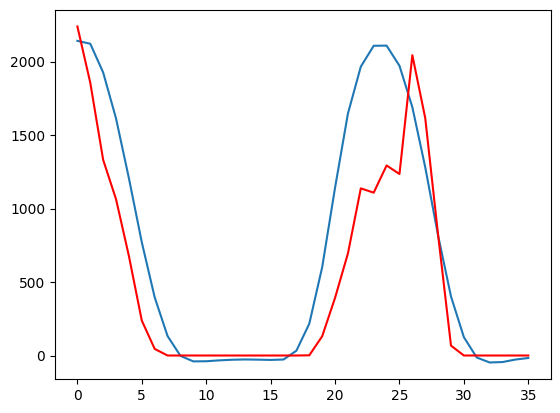

In [ ]:
plt.plot(predictions_unscaled[15])
plt.plot(y_test_unscaled[15], color='red')

##Trading algorithm (balancing)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

# Create a copy of the model
copied_model = tf.keras.models.clone_model(model)

# Compile the copied model
#copied_model.compile(optimizer=optimizer, loss='mean_squared_error')




In [ ]:
model_old = keras.models.load_model('my_model.h5')


82/82 [==============================] - 6s 74ms/step


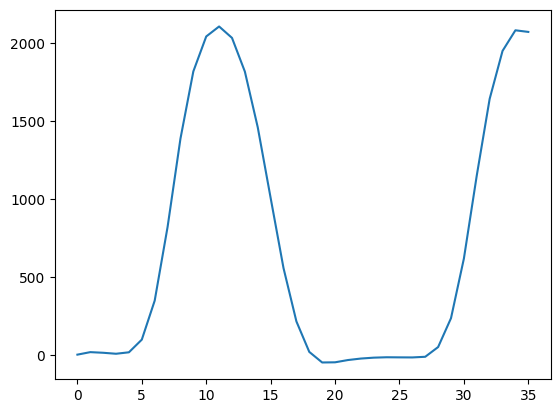

In [ ]:
predictions = model_old.predict([X_test,X_test])

num_samples, sequence_length, _ = predictions.shape
predictions_2d = predictions.reshape(-1, 1)




y_num_samples, y_sequence_length, _ = predictions.shape
y_2d = y_test.reshape(-1, 1)







# Scale back the data to its original scale
original_predictions = scaler.inverse_transform(predictions_2d)

# Reshape original predictions back to match the shape of the prediction array
original_predictions_reshaped = original_predictions.reshape(num_samples, sequence_length)


# Scale back the data to its original scale
original_y = scaler.inverse_transform(y_2d)

# Reshape original predictions back to match the shape of the prediction array
original_y_reshaped = original_y.reshape(y_num_samples, y_sequence_length)

plt.plot(original_predictions_reshaped[4])
plt.plot(y_2d[4], color='red')


7207.830543592443

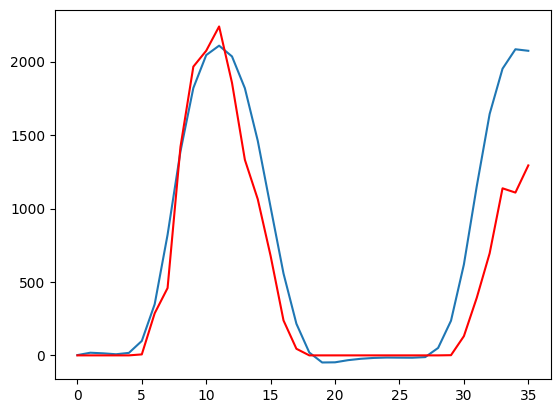

In [ ]:
plt.plot(original_predictions_reshaped[4])
plt.plot(original_y_reshaped[4], color='red')

FINAL FUNCTION

In [ ]:
import pandas as pd


def full_trading(date_from="2022-01-01",date_to="2023-01-01",API_credentials=('OeXk_h.ntyBg6u.XKAI8ABL.EwO9SVr3','ctDxT-K-QxltY_DStKkSI9.bUT7Yv1hXI7ycnYjsZQWvddQBWCPpdAHnTFtp4Lplrf1VWN_Tas0Xb4QDrwrmxlYdklMAcvsH8lRj')):


  session = wapi.Session(client_id=API_credentials[0], client_secret=API_credentials[1])

  def get_actual_prod(start_date=date_from, end_date=date_to):

    ## TIME_SERIES curve
    curve_a = session.get_curve(name='pro ch spv mwh/h cet min15 a')

    ## Hourly average aggregation
    # read curve data from start_date to end_date to ts object and
    # aggregate to hourly frequency
    ts1h_a = curve_a.get_data(data_from=start_date, data_to=end_date, function='AVERAGE',
                        frequency='H')

    # convert to pandas.Series object
    pd_s_a = ts1h_a.to_pandas() # convert TS object to pandas.Series object
    pd_df_a = pd_s_a.to_frame() # convert pandas.Series to pandas.DataFrame

    return pd_s_a


  actual_prod = get_actual_prod(start_date =start_date , end_date = end_date)
  #Step 1: getting the actual PV prod data
  actual_prod = get_actual_prod(start_date = "2022-01-01" , end_date = "2023-01-01")




  def get_spot_price(start_date, end_date):


    ## TIME_SERIES curve
    curve_sp = session.get_curve(name='pri ch spot €/mwh cet h a')

    ## Hourly average aggregation
    # read curve data from start_date to end_date to ts object and
    # aggregate to hourly frequency
    ts1h_sp = curve_sp.get_data(data_from=start_date, data_to=end_date, function='AVERAGE', frequency = 'H'
                        )

    # convert to pandas.Series object
    pd_s_sp = ts1h_sp.to_pandas() # convert TS object to pandas.Series object
    pd_df_sp = pd_s_sp.to_frame() # convert pandas.Series to pandas.DataFrame


    return pd_s_sp



  spot_price = get_spot_price(start_date = date_from , end_date =date_to)




  def get_cap_curve(start_date, end_date):

    ## TIME_SERIES curve
    curve_cap = session.get_curve(name='cap ch spv mw cet min15 a')

    ## Hourly average aggregation
    # read curve data from start_date to end_date to ts object and
    # aggregate to hourly frequency
    ts1h_cap = curve_cap.get_data(data_from=date_from, data_to=date_to, function='AVERAGE', frequency = 'H'
                        )

    # convert to pandas.Series object
    pd_s_cap = ts1h_cap.to_pandas() # convert TS object to pandas.Series object
    pd_df_cap = pd_s_cap.to_frame() # convert pandas.Series to pandas.DataFrame


    return pd_s_cap


  cap_curve = get_cap_curve(start_date = date_from , end_date = date_to)




  def pnl(actual_prod, pred_prod, spot_price, tot_cap):

    #PRE-ELIMINARY: Scale down the total Swiss production to our PV plant

    actual_prod = (actual_prod / tot_cap) * 10
    pred_prod = (pred_prod / tot_cap) * 10




    #List of hourly pnl's (will be converted to Series later)
    pnl_final = []


    for actual_prod_h,pred_prod_h,spot_price_h in zip(actual_prod.values, pred_prod.values, spot_price.values):

      pnl_spot = spot_price_h * pred_prod_h

      energy_imb = actual_prod_h - pred_prod_h


      #case of excess energy available:
      if energy_imb > 0:
        #sell at disadvantageous price
        price_imb = spot_price_h * 0.7

      # case of lack of energy
      elif energy_imb < 0:
        #buy at expensive price
        price_imb = spot_price_h * 1.3

      #case of perfect balance
      else:
        price_imb = 0


      pnl_imb = price_imb * energy_imb

      pnl_h = pnl_spot + pnl_imb


      pnl_final.append(pnl_h)


    #copy one of the Series
    pnl_final_series = actual_prod.copy()

    pnl_final_series.values[:] = pnl_final


    return pnl_final_series, pnl_final_series.sum()




  #----------------------------Feature Curves----------------------------------------



  def handle_data(session,date_from,date_to):
    PV_CAPACITY = "cap ch spv mw cet min15 a"

    CLOUD_FORECAST = 'cc ch con ec00 % cet min15 f'

    WIND_SPEED = ["ff ch grimsel test m/s cet h s",
                      "ff ch adelboden test m/s cet h s",
                      "ff ch geneve test m/s cet h s",
                      "ff ch davos test m/s cet h s",
                      "ff ch engelberg test m/s cet h s",
                      "ff ch bern test m/s cet h s",
                      "ff ch lugano test m/s cet h s",
                      "ff ch zurich test m/s cet h s",
                      "ff ch samedan test m/s cet h s"]

    TEMPERATURES = ["tt ch grimsel test °c cet h s",
                        "tt ch adelboden test °c cet h s",
                        "tt ch geneve test °c cet h s",
                        "tt ch davos test °c cet h s",
                        "tt ch engelberg test °c cet h s",
                        "tt ch bern test °c cet h s",
                        "tt ch lugano test °c cet h s",
                        "tt ch zurich test °c cet h s",
                        "tt ch samedan test °c cet h s"]


    OBSERVED_CONSUMPTION = "con ch mwh/h cet min15 a"


    Y = ACTUAL_PV_PRODUCTION = "pro ch spv mwh/h cet min15 a"



    def merge_mean(curves, session, data_from="2022-01-01", data_to="2022-12-31"):
      assert len(curves) > 0

      c = session.get_curve(name=curves[0])
      ts = c.get_data(data_from=data_from, data_to=data_to)
      res = ts.to_pandas().to_frame()

      for index, curve in enumerate(curves):
        if index == 0:
          continue

        tmp_c = session.get_curve(name=curve)
        tmp = tmp_c.get_data(data_from=data_from, data_to=data_to)
        res = res.join(tmp.to_pandas().to_frame())

      res = res.mean(axis=1).to_frame()
      res.rename(columns = {0:curves[0][:2]}, inplace = True)
      return res


    def generate_continuous(from_date = "2022-01-01", to_date = "2023-01-01"):
        features = []

        ## Installed PV Capacity - cap
        Installed_PV = session.get_curve(name=PV_CAPACITY)
        ts_Installed_PV = Installed_PV.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
        df_Installed_PV = ts_Installed_PV.to_pandas().to_frame()
        df_Installed_PV.rename(columns = {PV_CAPACITY: 'cap'}, inplace = True)

        ## Windspeed - ff
        df_wind_speed = merge_mean(WIND_SPEED, session, from_date, to_date)
        features.append(df_wind_speed)

        ## Temperatures - tt
        df_temperature = merge_mean(TEMPERATURES, session, from_date, to_date)
        features.append(df_temperature)

        ## Observed Consumption - con
        consumption = session.get_curve(name=OBSERVED_CONSUMPTION)
        ts_consumption = consumption.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
        df_consumption = ts_consumption.to_pandas().to_frame()
        df_consumption.rename(columns = {OBSERVED_CONSUMPTION : 'con'}, inplace = True)
        features.append(df_consumption)

        actual_pv_prod = session.get_curve(name=ACTUAL_PV_PRODUCTION)
        ts_actual_pv_prod = actual_pv_prod.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
        df_actual_pv_prod = ts_actual_pv_prod.to_pandas().to_frame()
        df_actual_pv_prod.rename(columns = {ACTUAL_PV_PRODUCTION : 'y'}, inplace = True)
        features.append(df_actual_pv_prod)


        return df_Installed_PV.join(features)



    def generate_static(timestamp='2022-01-01T00:00'):
      ## Cloud Coverage Forecast
      cc_forecast = session.get_curve(name=CLOUD_FORECAST)

      #ts_cc_list = cc_forecast.search_instances(issue_date_from=from_date,
      #                              issue_date_to=to_date,
      #                              with_data=True, frequency="H", function="AVERAGE")
      #ts_cc_forecast = cc_forecast.get_data(data_from=from_date, data_to=to_date, frequency="H", function="AVERAGE")
      ts_cc_forecast = cc_forecast.get_instance(issue_date=timestamp, frequency="H", function="AVERAGE")
      df_ts_cc_forecast = ts_cc_forecast.to_pandas().to_frame()

      return df_ts_cc_forecast




    dataset = generate_continuous(date_from,date_to)


    generate_static(timestamp=date_from)


    # Generate timestamps for every 10 days within the range
    timestamps = pd.date_range(start=date_from, end=date_to, freq='10D')

    # Create an empty list to store the DataFrames
    dataframes = []

    # Iterate over each timestamp and call the generate_static() method
    for timestamp in timestamps:
        # Convert the timestamp to a string in the required format
        timestamp_str = timestamp.strftime('%Y-%m-%d')

        # Call the generate_static() method with the current timestamp
        df_ts_cc_forecast = generate_static(timestamp=timestamp_str)

        # Get the current column name
        old_column_name = df_ts_cc_forecast.columns[0]

        # Rename the column to "cf"
        df_ts_cc_forecast.rename(columns={old_column_name: 'cf'}, inplace=True)



        #print(df_ts_cc_forecast)

        # Append the dataframe to the list
        dataframes.append(df_ts_cc_forecast)

    # Concatenate all DataFrames in the list into a single DataFrame
    result_df = pd.concat(dataframes, axis=0)


    # Filter the DataFrame to keep only rows from the year 2022
    df_2022 = result_df[result_df.index.year == 2022]
    df_final = pd.concat([dataset,df_2022],axis=1)


    # Preprocess the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_final.values.reshape(-1, 1))

    # Define the sequence length (number of time steps to look back)
    sequence_length = 36  # Use the past 24 hours to predict the next 24 hours

    # Prepare the data for Encoder-Decoder LSTM
    def create_dataset(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length - 36):
            X.append(data[i:i+sequence_length])
            y.append(data[i+sequence_length:i+sequence_length+36])
        return np.array(X), np.array(y)

    X, y = create_dataset(scaled_data, sequence_length)

    return (X,y)



  X,y = handle_data(session, date_from=date_from,date_to=date_to)
  #----------------------------Train LSTM model----------------------------------------



  my_model = keras.models.load_model('my_model.h5')


  def predict_pv_production(model, X, start_date, end_date):
      # Create an empty DataFrame to store the predictions
      predictions = pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='H'))

      # Convert start_date and end_date to pandas Timestamp objects
      start_date = pd.Timestamp(start_date)
      end_date = pd.Timestamp(end_date)

      # Check if X is a pandas DataFrame or a numpy array
      if isinstance(X, pd.DataFrame):
          # Iterate over the hours from start to end date
          current_date = start_date
          while current_date <= end_date:
              # Get the index location for the current date in X
              idx = X.index.get_loc(current_date)

              # Predict the next 36 hourly values using the model
              next_36_hours = model.predict([np.array(X.iloc[idx:idx+36]).reshape(1, 36, -1),
                                            np.array(X.iloc[idx:idx+36]).reshape(1, 36, -1)])

              # Store the predictions in the DataFrame
              predictions[current_date:current_date + pd.Timedelta(hours=35)] = next_36_hours.flatten()

              # Move to the next hour
              current_date += pd.DateOffset(days=1)
      elif isinstance(X, np.ndarray):
          # Iterate over the hours from start to end date
          current_date = start_date
          idx = 0
          while current_date <= end_date:
              # Predict the next 36 hourly values using the model
              next_36_hours = model.predict([X[idx:idx+36].reshape(1, 36, -1),
                                            X[idx:idx+36].reshape(1, 36, -1)])

              # Store the predictions in the DataFrame
              predictions[current_date:current_date + pd.Timedelta(hours=35)] = next_36_hours.flatten()

              # Move to the next hour
              current_date += pd.DateOffset(days=1)
              idx += 36

      predictions.to_csv('predictions.csv')


  predict_pv_production(my_model, X, date_from, date_to)

















































In [ ]:
full_trading()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_20' (type Functional).
    
    Input 0 of layer "lstm_41" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 36, 36)
    
    Call arguments received by layer 'model_20' (type Functional):
      • inputs=('tf.Tensor(shape=(None, 36, 36), dtype=float32)', 'tf.Tensor(shape=(None, 36, 36), dtype=float32)')
      • training=False
      • mask=None


In [ ]:
from datetime import datetime, timedelta
import numpy as np

def rolling_window_cross_validation(model, X_train, y_train, X_test, y_test, train_start=1440, step_size=720, test_size=36):
    pnl_plots = []
    pnl_scores = []

    # Calculate the total number of iterations
    total_iterations = (len(X_train) - train_start - test_size) // step_size + 1

    # Compile the model
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define a function to make predictions
    def make_predictions(model, data):
        predictions = model.predict([data,data])
        # Exclude the first 12 hours of predictions

        # Reshape predictions array to 2D array
        num_samples, sequence_length, _ = predictions.shape
        predictions_2d = predictions.reshape(-1, 1)

        # Scale back the data to its original scale
        original_predictions = scaler.inverse_transform(predictions_2d)

        # Reshape original predictions back to match the shape of the prediction array
        original_predictions_reshaped = original_predictions.reshape(num_samples, sequence_length)

        return original_predictions_reshaped[:, 12:]


    # Iterate through the time series in rolling windows
    for i in range(total_iterations):
        # Define the training and testing sets for this iteration
        train_end = train_start + i * step_size

        # Retrain the model using new data only
        model.fit([X_train[train_end-step_size:train_end], X_train[train_end-step_size:train_end]],
                  y_train[train_end-step_size:train_end], epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

        # Make predictions for the next 36 hours
        predictions = make_predictions(model, X_test)

        # Update the predictions to exclude the first 12 hours
        if i > 0:
            predictions[0] = y_train[train_end:train_end+24]  # Replace the first 12 hours with actual production

        # Calculate PnL for each hour
        pnl_hour = pnl(actual_prod[train_end:train_end+24], predictions, spot_price[train_end:train_end+24], cap_curve[train_end:train_end+24])
        pnl_plots.append(pnl_hour)

        # Calculate cumulative PnL
        pnl_cumulative = np.sum(pnl_plots)
        pnl_scores.append(pnl_cumulative)

    return pnl_plots, pnl_scores


End

In [ ]:
# Define the Encoder-Decoder LSTM model
  # Encoder
  encoder_inputs = Input(shape=(sequence_length, 1))
  encoder = LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  encoder_states = [state_h, state_c]

  # Decoder
  decoder_inputs = Input(shape=(36, 1))
  decoder_lstm = LSTM(units=128, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_dense = Dense(units=1)
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  # Compile the model
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  model.save_weights('model_weights.h5')

  # Early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=2)

  # Train the model
  model.fit([X_train, X_train], y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

  # Evaluate the model
  train_loss = model.evaluate([X_train, X_train], y_train, verbose=0)
  test_loss = model.evaluate([X_test, X_test], y_test, verbose=0)
  print('Train Loss:', train_loss)
  print('Test Loss:', test_loss)
